# DQN Training
Training a DQN agent using custom gym environment and keras-rl2.

# Imports

In [52]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from gym import Env
from gym.spaces import Discrete, Box

from rl.agents import DQNAgent
from rl.policy import MaxBoltzmannQPolicy
from rl.memory import SequentialMemory

## Functions

In [53]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

# Environment

## Loading Shape Class

In [54]:
import sys  
sys.path.insert(0, "E:\Projects\Python\TetrisRoyaleRL")

from settings import *
from game_env.shapes import Shape

## Reworking the Environment

In [58]:
class GameEnv(Env):
    def __init__(self):
        # spaces
        self.action_space = Discrete(5)
        self.observation_space = Box(low=0.0, high=1.0, shape=(20, 10, 3))
        
        # state
        self.game_over = None

        # coord
        self.map = None

        # shape
        self.shape = None
        self.next_shape = None

        # init env
        self._state_gen()

    def _state_gen(self):
        self.game_over = False
        
        self.map = np.ones((GAME_SHAPE_TOP_HIDDEN + 20 + GAME_SHAPE_BORDERS,
                            GAME_SHAPE_BORDERS + 10 + GAME_SHAPE_BORDERS), dtype=np.int32)
        self.map[0: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0
        
        self.shape = Shape()
        self.next_shape = Shape()

    def _state_observe(self):
        # observable map
        temp_map = self.map[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS].copy()
        
        # observation of cur shape on map
        temp_shape = np.zeros(self.map.shape)
        x0 = self.shape.x
        y0 = int(self.shape.y)
        this_shape = self.shape.get_shape()
        temp_shape[y0: y0 + this_shape.shape[0], x0: x0 + this_shape.shape[1]] += this_shape
        temp_shape = temp_shape[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        
        # next shape on map, assuming y0 = 0
        temp_next_shape = np.zeros((20, 10))
        x0 = self.next_shape.x
        next_shape = self.next_shape.get_shape()
        temp_next_shape[0: next_shape.shape[0], x0: x0 + next_shape.shape[1]] += next_shape

        return np.stack([temp_map, temp_shape, temp_next_shape], axis=-1).astype(np.float32)

    def render(self):
        pass
    
    def reset(self):
        # restart state
        self._state_gen()
        # not terminal
        return self._state_observe()

    def step(self, action):
        reward = 0
        # 0 is skip
        # 1 is left
        if action == 1:
            if self.can_move(self.shape.x - 1, int(self.shape.y), self.shape.get_shape()):
                self.shape.x -= 1
            else:
                reward -= 1
        # 2 is right
        elif action == 2:
            if self.can_move(self.shape.x + 1, int(self.shape.y), self.shape.get_shape()):
                self.shape.x += 1
            else:
                reward -= 1
        # 3 is down
        elif action == 3:
            if self.can_move(self.shape.x, int(self.shape.y + 1), self.shape.get_shape()):
                self.shape.y += 1
            else:
                reward -= 1
        # 4 is rotate
        elif action == 4:
            if self.can_move(self.shape.x, int(self.shape.y), self.shape.get_rotated()):
                self.shape.rotate()
            else:
                reward -= 1
        # move down
        if self.can_move(self.shape.x, int(self.shape.y + FALL_SPEED), self.shape.get_shape()):
            self.shape.y += FALL_SPEED
        else:
            self.lock_figure()
        
        reward += self.remove_full_rows()

        return self._state_observe(), reward, self.game_over, {}


    def at(self, x, y):
        return self.map[GAME_SHAPE_TOP_HIDDEN + y, GAME_SHAPE_BORDERS + x]

    def can_move(self, x0, y0, figure):
        temp = self.map.copy()
        temp[int(y0): int(y0 + figure.shape[0]), x0: x0 + figure.shape[1]] += figure
        if 2 in temp:
            return False
        else:
            return True

    def lock_figure(self):
        x = self.shape.x
        y = int(self.shape.y)
        figure = self.shape.get_shape()
        self.map[y: y + figure.shape[0], x: x + figure.shape[1]] += figure
        self.shape = self.next_shape
        self.next_shape = Shape()
        if y < GAME_SHAPE_TOP_HIDDEN:
            self.game_over = True

    def remove_full_rows(self):
        reward = 0
        full = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        full = np.where(full.sum(axis=1) == 10)[0]
        if full.size > 0:
            reward = full.size * 10

            # to get indexes of the game screen
            full = full + GAME_SHAPE_TOP_HIDDEN

            # remove full rows
            self.map[full, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0

            # get non-empty rows
            partial = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
            partial = np.where(partial.sum(axis=1) != 0)[0]

            # if there are levitating non-empty rows
            if partial.size > 0:
                # get their indexes
                partial = partial + GAME_SHAPE_TOP_HIDDEN
                bottom = self.map.shape[0] - GAME_SHAPE_BORDERS
                # move them to bottom
                self.map[bottom-partial.size: bottom, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = \
                    self.map[partial, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
                # everything above must be cleared
                self.map[0: bottom-partial.size, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0
        return reward

## Create env

In [59]:
env = GameEnv()

## Test

In [62]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    while not done:
        action = np.random.randint(0, 5)
        n_state, reward, done, info = env.step(action)
        score+=reward
    print("Episode: {}, Score: {}".format(episode, score))

Episode: 1, Score: -85
Episode: 2, Score: -99
Episode: 3, Score: -119
Episode: 4, Score: -75
Episode: 5, Score: -77
Episode: 6, Score: -98
Episode: 7, Score: -77
Episode: 8, Score: -151
Episode: 9, Score: -101
Episode: 10, Score: -81
Episode: 11, Score: -78
Episode: 12, Score: -76
Episode: 13, Score: -108
Episode: 14, Score: -56
Episode: 15, Score: -92
Episode: 16, Score: -72
Episode: 17, Score: -125
Episode: 18, Score: -132
Episode: 19, Score: -116
Episode: 20, Score: -99
Episode: 21, Score: -86
Episode: 22, Score: -139
Episode: 23, Score: -80
Episode: 24, Score: -69
Episode: 25, Score: -117


# Nural Network and Agent

## Build model

In [63]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [64]:
def build_model():
    return tf.keras.Sequential([
    # 1 state, 20 rows, 10 cols, 3 matricies: locked, falling and next figures
    layers.Input(shape=(1, 20, 10, 3)),
    layers.Reshape(target_shape=(20, 10, 3)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    
    layers.Dense(32),
    layers.Activation("relu"),
    
    layers.Dense(16),
    layers.Activation("relu"),
    
    layers.Dense(5)])

In [65]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 20, 10, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 10, 32)        896       
                                                                 
 activation_4 (Activation)   (None, 20, 10, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 5, 32)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 5, 64)         18496     
                                                                 
 activation_5 (Activation)   (None, 10, 5, 64)         0         
                                                      

## Agent

In [66]:
env.observation_space.shape, env.action_space.n

((20, 10, 3), 5)

In [82]:
def build_agent(model):
    policy = MaxBoltzmannQPolicy(eps=0.8)
    memory = SequentialMemory(limit=2048, window_length=1)
    dqn = DQNAgent(model=model, 
        memory=memory,
        policy=policy,
        nb_actions=5,
        gamma=0.99,
        nb_steps_warmup=256,
        batch_size=64,
        target_model_update=0.01,
        enable_double_dqn=True,
        enable_dueling_network=True)
    return dqn

In [83]:
dqn = build_agent(model)
dqn.compile(tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0), metrics=["mean_squared_error"])

In [84]:
dqn.load_weights("saved/dqn_v1.h5")

#from keras import backend as K
#print(K.eval(dqn.model.optimizer.learning_rate))
#K.set_value(dqn.model.optimizer.learning_rate, 0.001)
#print(K.eval(dqn.model.optimizer.learning_rate))

## Training

In [88]:
history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=1, log_interval=5000)

Training for 50000 steps ...
Interval 1 (0 steps performed)
5000/5000 [==============================] - 141s 28ms/step - reward: -0.0584
5 episodes - episode_reward: -58.000 [-78.000, -39.000] - loss: 0.029 - mean_squared_error: 23.677 - mean_q: 5.584

Interval 2 (5000 steps performed)
5000/5000 [==============================] - 150s 30ms/step - reward: -0.0714
6 episodes - episode_reward: -59.333 [-75.000, -47.000] - loss: 0.022 - mean_squared_error: 19.739 - mean_q: 5.095

Interval 3 (10000 steps performed)
5000/5000 [==============================] - 161s 32ms/step - reward: -0.0658
6 episodes - episode_reward: -51.500 [-76.000, -29.000] - loss: 0.026 - mean_squared_error: 22.732 - mean_q: 5.473

Interval 4 (15000 steps performed)
5000/5000 [==============================] - 173s 35ms/step - reward: -0.0842
6 episodes - episode_reward: -74.000 [-102.000, -59.000] - loss: 0.029 - mean_squared_error: 20.479 - mean_q: 5.182

Interval 5 (20000 steps performed)
5000/5000 [=============

## Save Weights

In [89]:
dqn.save_weights("saved/dqn_v2.h5", overwrite=True)

## Plot

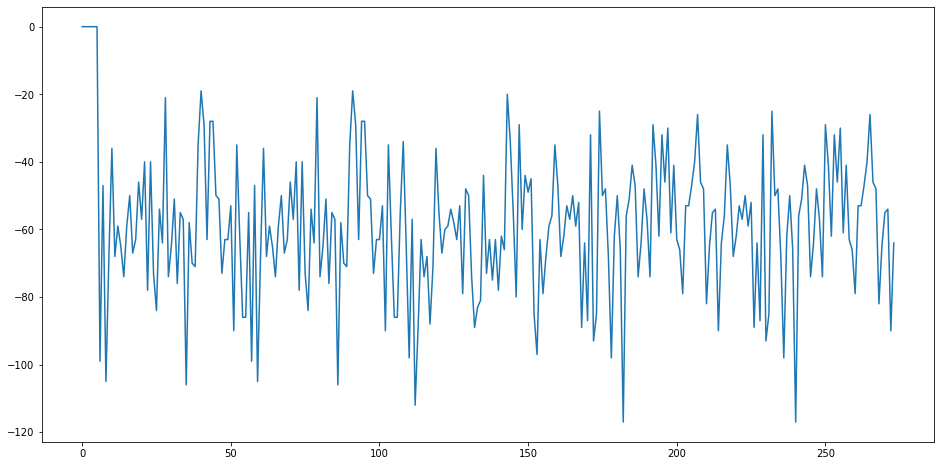

In [87]:
# load history
full_hist = np.load("saved/history.npy")
# concat old and new history
full_hist = np.concatenate((full_hist, np.array(history.history["episode_reward"])))
# save history
np.save("saved/history.npy", full_hist)

plt.rcParams["figure.figsize"] = (16, 8)
#plt.plot(moving_average(full_hist, 10))
plt.plot(full_hist)
plt.show()